# Natural Language Processing - Group Assignment Task 2
## Group 6
##### Robert Brunnsteiner, Mohammad Mahdi Fallah, Akshey Kumar, Jan-Jonas Schumacher
VU Data Mining (WS 2021/22)

### Task:

Task-2 is about exploring the potential of CNNs (Convolutional Neural Networks) for text classification and more specifically for sentiment analysis [12]. The generic CNN architecture you need to use is depicted in Figure 1. The dataset to be used is the IMDB Movie review dataset described in [16]. It consists of 25 000 positive and 25 000 negative movie reviews and is available for free. There are also 50 000 unlabeled samples which will not be used for this task. After extracting the downloaded archive, you should collect the texts of each file, organize them as a dataframe and store it as a CSV file. For this, you can run the code of Listing 1 on the same path where you have aclImdb folder.

## Imports and requirements

In [49]:
#!pip install -r requirements.txt

# Task 2a
import os
import pandas as pd
from sklearn.utils import shuffle
import string, nltk
from nltk.tokenize import RegexpTokenizer
import re

# Task 2b and 2c
import numpy as np
import random, sys
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Conv1D, GlobalMaxPooling1D, MaxPooling1D, AveragePooling1D, Flatten, Concatenate, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
import pydot
import graphviz
import matplotlib.pyplot as plt
import keras_tuner as kt



## NLP Task 2-a
Task: In this step you will perform preprocessing of the review part of each data sample. Start by printing the raw review field of a dataframe sample with index X (you pick X yourself). Then, write a function to preprocess the texts and apply it in each review cell of the dataframe entries. The function must lowercase the text. It must also replace every number occurrence (integer or float) with a single ‘#’ symbol. Furthermore, you should make sure to keep (or save and add again) all smiley symbols which are very helpful sentiment polarityanalysis features. Besides‘#’ and smileys, all other punctuation or special symbols must be removed. After applying the function in the entire dataframe print the preprocessed text of the same sample X to show how it changed.

### Our approach:
Write something here...

In [6]:
# Listing 1: Python code for preparing IMDB movie review dataset
# Runtime ~1 minute

labels = {'pos':1, 'neg':0} # data labels
df = pd.DataFrame() # dataframe for holding the samples

# walking through the folder structure
for s in ('test', 'train'): 
    for l in ('pos', 'neg'):
        path ='./aclImdb/%s/%s' % (s, l) 
        for file in os.listdir (path):
            with open(os.path.join(path, file), 'r', encoding='utf8') as infile:
                txt = infile.read () # read content of each file
            df = df.append([[txt , labels[l]]], ignore_index=True)

# name of data columns
df.columns = ['review', 'polarity']
# randomly shuffle dataframe samples
df = shuffle(df, random_state=7)
# save dataframe to CSV file
df.to_csv ('./review_samples.csv', index=False)

In [7]:
# preprocess function
def preprocess(dataset):
    rows = dataset.shape[0]
    
    #this tokenizer takes words, the # symbol and smilies as tokens and discards the rest
    tokenizer = RegexpTokenizer(r'\w+|#|(?::|;|=)(?:-)?(?:\)|\(|\\|\/|D|P)')
    
    #loop over all rows and preprocess the reviews
    for i in range(rows):
        # text to lower case
        dataset.iloc[i, 0] = (dataset.iloc[i, 0]).lower()
        # substitute floats and integers to #
        dataset.iloc[i, 0] = re.sub(r'[+-]?([0-9]*[.])?[0-9]+', '#', dataset.iloc[i, 0])
        # remove punctuation other than # and smilies using the tokenizer defined above
        dataset.iloc[i, 0] = ' '.join(tokenizer.tokenize(dataset.iloc[i, 0]))

### Results:

In [8]:
# Write/show Results here?

In [9]:
# Runtime ~4 minutes
data = pd.read_csv('review_samples.csv')
print(data.iloc[1337, 0])

print('***********************************')

preprocess(data)
print(data.iloc[1337, 0])
data.to_csv ('./review_preprocessed.csv', index=False)

I know it sounds crazy but yes, I am a huge fan of House Party 1 and 2 (and proud of it!!). I hated part 3, and then here comes part 4. I was like are you kidding me with this? Kid 'n Play are nowhere to be found in this movie, and that would've been okay, had they not foolishly entitled the movie House Party 4, as if it was in any way, shape, form, or fashion related to its predecessors. Every time this movie comes on late at night on USA, I shoot my TV with a rifle. Quite frankly, it really is just that atrocious. *hurling*<br /><br />As the only remaining fan of Kid 'n Play that will actually admit to being a fan (tee hee hee), I was appalled. Remember that stupid little boy group Immature? They snuck their way into House Party 3. Okay, fine and well but how can part 4 be just about them and nothing else and it also seems like they're not even the same kids from part 3. *confused!!!!* House Party fans: do yourself a favor and stick to House Party 1 and 2 and Class Act. Beyond that, 

## NLP Task 2-b
Task: In this step you will implement a “vanilla” model of the architecture. 
For this you will need to use PyTorch or Tensorflow/Keras functional API and various layers
like Input, Embedding, Conv1D, Dropout, MaxPooling1D, Flatten, concatenate, Dense, etc. as well as
other utility functions such as Tokenizer. For some of the parameters, you should consider the values
suggested in Table 1. Please note that those values are “typical” but not necessarily optimal. First, you need to tokenize the texts and cut/pad them to a common max length size. Then you derive the train and test samples and labels. The “vanilla” model should contain the Embedding layer, a single convolution layer of only one block followed by a max-pooling layer and a single dense layer. You will report the classification accuracy of this model.


### Our appraoch:
Write something here..

#### Parameters (Recommendation)

W or number of convolution blocks in each layer: 2-5.  
L or number of consecuetive convolution-pooling layers: 2-4  
Maximal length of each review sequence: 300-500    
Dimension of word embbeddings: 150-300.  
Train : Test split of the data samples: 4:1 or 9:1.  
Number of filters in each convolution layer: 10-50.  
Kernel size in each convolution block: 1-5.  

Here we set up the parameters for our model.

In [50]:
# Number of convolution blocks in each layer
# W = 1
# Number of consecuetive convolution-pooling layers
# L = 1
#  Max lenght of each review sequence
UNIFORM_LENGTH = 300
# The dimension of the word embeddings
WORD_EMBEDDING_DIM = 150
# Train : Test split
SPLIT_DATA = 0.8
# Number of filters in each convolution layer
CONV_FILTERS = 10
# Kernel size in each convolution block
KERNEL_SIZE = 1
# Vocabulary: number of most frequent words
VOCABULARY = 30000
# POOL_SIZE: Downsamples the input representation by taking the maximum value 
POOL_SIZE = 2
# Training and evaluation:
EPOCHS = 3
BATCH_SIZE = 16
VERBOSE = 1

### Loading and preparing data

Loading the pre-processed data and splitting them into train and test sets. Random state is fixed for reproducibility.

In [51]:
df = pd.read_csv('review_preprocessed.csv')
training_data = df.sample(frac=SPLIT_DATA, random_state=25)
testing_data = df.drop(training_data.index)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 40000
No. of testing examples: 10000


In [52]:
### Converting the pandas dataframe to lists and numpy arrays
X_train = training_data.loc[:,'review'].to_list()
X_test = testing_data.loc[:,'review'].to_list()
y_train = training_data.loc[:,'polarity'].to_numpy()
y_test = testing_data.loc[:,'polarity'].to_numpy()

In [53]:
### Variables for original (not vectorized) data
X_train_text = X_train
X_test_text = X_test

The Tokenize class helps us to vectorize a text corpus by tunring them into a sequence of integers. 

In [54]:
t  = Tokenizer(num_words = VOCABULARY)

t.fit_on_texts(X_train)
X_train_enc = t.texts_to_sequences(X_train)
X_test_enc = t.texts_to_sequences(X_test)

Here we force a uniform length for each review. Longer reviews are truncated and shorted reviews and padded with zeros.

In [55]:
X_train_pad = pad_sequences(X_train_enc, maxlen=UNIFORM_LENGTH)
X_test_pad = pad_sequences(X_test_enc, maxlen=UNIFORM_LENGTH)

X_train = X_train_pad
X_test = X_test_pad

### CNN vanilla model 

In [56]:
### With Keras functional API
inputs = Input(shape=(UNIFORM_LENGTH,))
x = Embedding(VOCABULARY, WORD_EMBEDDING_DIM, input_length=UNIFORM_LENGTH)(inputs)
x = Conv1D(filters=CONV_FILTERS, kernel_size=KERNEL_SIZE, activation='relu')(x)
x = MaxPooling1D(pool_size=POOL_SIZE)(x)
x = Flatten()(x)
x = Dropout(.8)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_8 (Embedding)     (None, 300, 150)          4500000   
                                                                 
 conv1d_33 (Conv1D)          (None, 300, 10)           1510      
                                                                 
 max_pooling1d_33 (MaxPoolin  (None, 150, 10)          0         
 g1D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 1500)              0         
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                           

In [57]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Callback for tensorboard VIS
tb_callback = callbacks.TensorBoard(log_dir="logs/", histogram_freq=1)
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback])

Epoch 1/3
2000/2000 [==============================] - 64s 32ms/step - loss: 0.5794 - accuracy: 0.6718 - val_loss: 0.3739 - val_accuracy: 0.8487
Epoch 2/3
2000/2000 [==============================] - 65s 33ms/step - loss: 0.4059 - accuracy: 0.8173 - val_loss: 0.3386 - val_accuracy: 0.8622
Epoch 3/3
2000/2000 [==============================] - 64s 32ms/step - loss: 0.3471 - accuracy: 0.8503 - val_loss: 0.3220 - val_accuracy: 0.8656


In [58]:
# Evaluate Vanilla model
score = model.evaluate(X_test, y_test)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

313/313 [==============================] - 1s 2ms/step - loss: 0.3193 - accuracy: 0.8669
Test loss: 0.31926026940345764 / Test accuracy: 0.8669000267982483


### Results:



#### Accuracy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


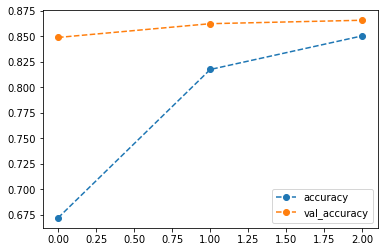

In [60]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'], label = "accuracy", linestyle='--', marker='o')
plt.plot(history.history['val_accuracy'], label = "val_accuracy", linestyle='--', marker='o')
plt.legend()
plt.show()

#### Investigating the missclassified results

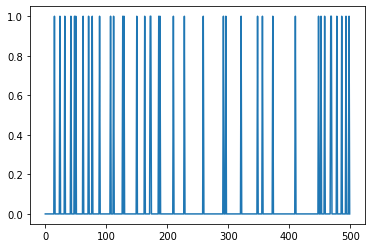

Review: 15
it s partly bad luck for illuminata that it comes out after shakespeare in love as it deals with virtually the same themes of life as art art as life and the magic of the theatre and the same archetypal foibles of theater folk but a whole lot more ponderously br br there are scenes that come alive as a play develops and gets reinterpreted by a writer s life but there s a whole lot of orson welles ish ego in this produced by directed by lead acted by john torturro as a vehicle for his wife katharine borowitz with an adorable cameo by their son br br each actor gets his her moment literally in the spotlight but there s so many masques or set pieces that seem like # th century parlor games bill irwin talks susan sarandon gets to be a diva christopher walken gets to be a different kind of villain a gay critic the women have to disrobe unnecessarily because this is an art film br br the art and set direction are marvelous though quite dark this should get an award as the best use

/var/folders/5v/wrnrfs9x5z30cjvp_ytqb1pc0000gn/T/ipykernel_43620/192086885.py:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  wrong_class=[X_test_text[i] for i in difference]


In [62]:
amount = 500
ypred = (model(X_train[:amount]).numpy() > 0.5).astype(int).reshape(amount)
difference =  ypred != y_train[:amount]
plt.plot(difference)
plt.show()
wrong_idx = list(np.where(difference)[0])
wrong_class=[X_test_text[i] for i in difference]
False_negative = 0
False_positive = 0
for i in range(0, len(wrong_idx)):
    
    print("Review:", wrong_idx[i])
    print(X_test_text[i])
    print("Correct:", y_train[wrong_idx[i]], "Prediction:",  ypred[wrong_idx[i]])
    if(y_train[wrong_idx[i]] == 1):
        print("False negative")
        False_negative += 1
    if(y_train[wrong_idx[i]] == 0):
        print("False positive")
        False_positive += 1
    print("********************")
    


21 18


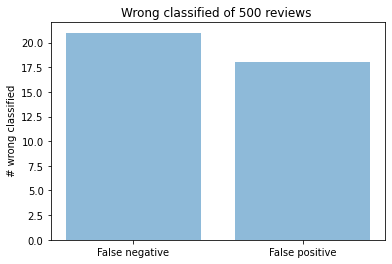

In [63]:
print(False_negative, False_positive)
objects = ('False negative', 'False positive')
y_pos = np.arange(len(objects))
performance = [False_negative, False_positive]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel(' # wrong classified')
plt.title(f'Wrong classified of {amount} reviews ')

plt.show()

### CNN vanilla model with keras tuner


In [64]:
def call_existing_code(LEARNING_RATE, VOCABULARY, WORD_EMBEDDING_DIM, UNIFORM_LENGTH, CONV_FILTERS, KERNEL_SIZE, DROPOUT):
    inputs = Input(shape=(UNIFORM_LENGTH,))
    x = Embedding(VOCABULARY, WORD_EMBEDDING_DIM, input_length=UNIFORM_LENGTH)(inputs)
    x = Conv1D(filters=CONV_FILTERS, kernel_size=KERNEL_SIZE, activation='relu')(x)
    x = MaxPooling1D(pool_size=POOL_SIZE)(x)
    x = Flatten()(x)
    x = Dropout(DROPOUT)(x)
    x = Dense (100, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    plot_model(model, to_file='vanilla_model.png', show_shapes=True)
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        #optimizer='adam',
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


def build_model(hp):
    LEARNING_RATE = hp.Float('learning_rate',min_value=1e-5,max_value=1e-2,sampling='LOG',default=1e-3)
    VOCABULARY = 30000
    WORD_EMBEDDING_DIM = hp.Int("output_dim", min_value=150, max_value=300, step=50)
    UNIFORM_LENGTH = 300
    CONV_FILTERS = hp.Int("filters", min_value=10, max_value=50, step=10)
    KERNEL_SIZE = hp.Int("kernel_size", min_value=1, max_value=5, step=1)
    DROPOUT = hp.Float('dropout', min_value=0.0, max_value=0.8, default=0.5, step=0.1)

    # call existing model-building code with the hyperparameter values.
    model = call_existing_code(
        LEARNING_RATE = LEARNING_RATE,
        VOCABULARY=VOCABULARY, 
        WORD_EMBEDDING_DIM=WORD_EMBEDDING_DIM, 
        UNIFORM_LENGTH=UNIFORM_LENGTH, 
        CONV_FILTERS=CONV_FILTERS, 
        KERNEL_SIZE=KERNEL_SIZE,
        DROPOUT = DROPOUT
        )

    return model

build_model(kt.HyperParameters())


In [65]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=4,
    overwrite=True,
    directory="tmp/tb")
    
tuner.search_space_summary()

Search space summary
Default search space size: 5
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
output_dim (Int)
{'default': None, 'conditions': [], 'min_value': 150, 'max_value': 300, 'step': 50, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 50, 'step': 10, 'sampling': None}
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
dropout (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': 0.1, 'sampling': None}


In [66]:
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=8, validation_split=0.2, callbacks=[stop_early, callbacks.TensorBoard("tmp/tb_logs")])
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 10 Complete [00h 04m 36s]
val_accuracy: 0.9011250138282776

Best val_accuracy So Far: 0.9011250138282776
Total elapsed time: 00h 28m 25s
INFO:tensorflow:Oracle triggered exit


Train model:

In [67]:
# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=8, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/8
1000/1000 [==============================] - 70s 70ms/step - loss: 0.6195 - accuracy: 0.6277 - val_loss: 0.3433 - val_accuracy: 0.8671
Epoch 2/8
1000/1000 [==============================] - 69s 69ms/step - loss: 0.2812 - accuracy: 0.8839 - val_loss: 0.2565 - val_accuracy: 0.8971
Epoch 3/8
1000/1000 [==============================] - 71s 71ms/step - loss: 0.1852 - accuracy: 0.9303 - val_loss: 0.2492 - val_accuracy: 0.8980
Epoch 4/8
1000/1000 [==============================] - 70s 70ms/step - loss: 0.1345 - accuracy: 0.9515 - val_loss: 0.2687 - val_accuracy: 0.8966
Epoch 5/8
1000/1000 [==============================] - 70s 70ms/step - loss: 0.0995 - accuracy: 0.9651 - val_loss: 0.2824 - val_accuracy: 0.8965
Epoch 6/8
1000/1000 [==============================] - 71s 71ms/step - loss: 0.0772 - accuracy: 0.9733 - val_loss: 0.3480 - val_accuracy: 0.8835
Epoch 7/8
1000/1000 [==============================] - 71s 71ms/step - loss: 0.0595 - accuracy: 0.9793 - val_loss: 0.3372 - val_ac

In [68]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/3
1000/1000 [==============================] - 71s 70ms/step - loss: 0.5950 - accuracy: 0.6499 - val_loss: 0.3352 - val_accuracy: 0.8656
Epoch 2/3
1000/1000 [==============================] - 70s 70ms/step - loss: 0.2723 - accuracy: 0.8892 - val_loss: 0.2534 - val_accuracy: 0.8994
Epoch 3/3
1000/1000 [==============================] - 74s 74ms/step - loss: 0.1844 - accuracy: 0.9299 - val_loss: 0.2455 - val_accuracy: 0.8994


Evaluate on test data

In [69]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 4ms/step - loss: 0.2583 - accuracy: 0.8957
[test loss, test accuracy]: [0.25828951597213745, 0.8956999778747559]


### Results

In [3]:
#!kill 43071
#%load_ext tensorboard
%tensorboard --logdir ./tmp/tb_logs

In [71]:
best_hps=tuner.get_best_hyperparameters()[0]
print("Optimal parameter for CONV_FILTERS: ", best_hps.get('filters'))
print("Optimal parameter for WORD_EMBEDDING_DIM: ", best_hps.get('output_dim'))
print("Optimal parameter for KERNEL_SIZE: ", best_hps.get('kernel_size'))
print("Optimal parameter for DROPOUT: ", best_hps.get('dropout'))
print("Optimal parameter for EPOCH: ", best_epoch)
print("Optimal parameter for LEARNING_RATE: ", best_hps.get('learning_rate'))

Optimal parameter for CONV_FILTERS:  10
Optimal parameter for WORD_EMBEDDING_DIM:  250
Optimal parameter for KERNEL_SIZE:  3
Optimal parameter for DROPOUT:  0.5
Optimal parameter for EPOCH:  3
Optimal parameter for LEARNING_RATE:  0.00011140779568572232


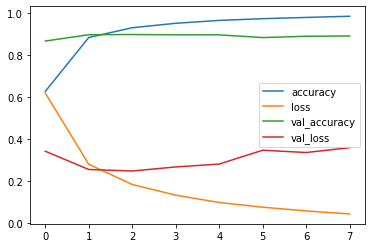

In [72]:
#print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'], label = "accuracy")
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_accuracy'], label = "val_accuracy")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend()
plt.show()

#### Investigating the missclassified results

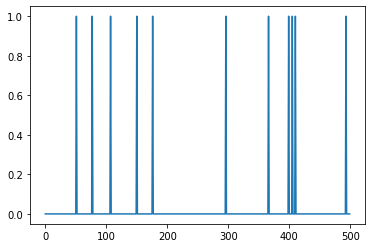

Review: 51
it s partly bad luck for illuminata that it comes out after shakespeare in love as it deals with virtually the same themes of life as art art as life and the magic of the theatre and the same archetypal foibles of theater folk but a whole lot more ponderously br br there are scenes that come alive as a play develops and gets reinterpreted by a writer s life but there s a whole lot of orson welles ish ego in this produced by directed by lead acted by john torturro as a vehicle for his wife katharine borowitz with an adorable cameo by their son br br each actor gets his her moment literally in the spotlight but there s so many masques or set pieces that seem like # th century parlor games bill irwin talks susan sarandon gets to be a diva christopher walken gets to be a different kind of villain a gay critic the women have to disrobe unnecessarily because this is an art film br br the art and set direction are marvelous though quite dark this should get an award as the best use

/var/folders/5v/wrnrfs9x5z30cjvp_ytqb1pc0000gn/T/ipykernel_43620/890733325.py:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  wrong_class=[X_test_text[i] for i in difference]


In [73]:
amount = 500
ypred = (hypermodel(X_train[:amount]).numpy() > 0.5).astype(int).reshape(amount)
difference =  ypred != y_train[:amount]
plt.plot(difference)
plt.show()
wrong_idx = list(np.where(difference)[0])
wrong_class=[X_test_text[i] for i in difference]
False_negative = 0
False_positive = 0
for i in range(0, len(wrong_idx)):
    
    print("Review:", wrong_idx[i])
    print(X_test_text[i])
    print("Correct:", y_train[wrong_idx[i]], "Prediction:",  ypred[wrong_idx[i]])
    if(y_train[wrong_idx[i]] == 1):
        print("False negative")
        False_negative += 1
    if(y_train[wrong_idx[i]] == 0):
        print("False positive")
        False_positive += 1
    print("********************")

6 5


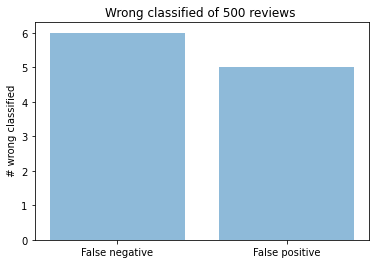

In [74]:
print(False_negative, False_positive)
objects = ('False negative', 'False positive')
y_pos = np.arange(len(objects))
performance = [False_negative, False_positive]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel(' # wrong classified')
plt.title(f'Wrong classified of {amount} reviews ')

plt.show()

### Conclusion of Task 2(b)
The optimal parameters obtained in task 2(b) were a word embedding dimension of 200 and 30 convolution filters. Those are now used in task 2(c)

## NLP Task 2-c

In [75]:
def set_elaborate_model(vocabulary, word_embedding_dim, uniform_length, conv_filters, W, L):
    inputs = Input(shape=(uniform_length,))
    x = Embedding(vocabulary, word_embedding_dim, input_length=uniform_length)(inputs)
    
    #convolutional layers
    for l in range (L):
        c = []
        for w in range(W):
            if l == 0:
                c.append(Conv1D(filters=conv_filters, kernel_size=w+1, activation='relu')(x))
            else:
                c.append(Conv1D(filters=conv_filters, kernel_size=w+1, activation='relu')(p[w]))
        p = []
        for w in range(W):    
            p.append(MaxPooling1D(pool_size=POOL_SIZE)(c[w]))

    x = Concatenate(axis=1)(p)
    x = Flatten()(x)
    x = Dense (100, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    plot_model(model, to_file='elaborate_model.png', show_shapes=True)
    model.compile(
        #optimizer=keras.optimizers.Adam(learning_rate=lr), ### Uncomment this to tune learning rate
        optimizer='adam',
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

elaborate_model = set_elaborate_model(VOCABULARY, 200, UNIFORM_LENGTH, 30, 3, 2)

In [76]:
history = elaborate_model.fit (X_train, y_train, batch_size=BATCH_SIZE, epochs=2, validation_data=(X_test, y_test))

Epoch 1/2
2500/2500 [==============================] - 201s 80ms/step - loss: 0.3167 - accuracy: 0.8558 - val_loss: 0.2653 - val_accuracy: 0.8950
Epoch 2/2
2500/2500 [==============================] - 184s 74ms/step - loss: 0.1428 - accuracy: 0.9476 - val_loss: 0.2813 - val_accuracy: 0.8940


In [77]:
print (history.history['val_accuracy'][-1])

0.8939999938011169


In [78]:
# grid search for W and L

W = [2, 3, 4, 5]
L = [2, 3, 4]

for w in W:
    for l in L:
            elaborate_model = set_elaborate_model(VOCABULARY, 200, UNIFORM_LENGTH, 30, w, l)
            history = elaborate_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=2, validation_data=(X_test, y_test))
            print (f"Validation Accuracy with W={w} and L={l}: {history.history['val_accuracy'][-1]}.")

Epoch 1/2
2500/2500 [==============================] - 160s 64ms/step - loss: 0.3175 - accuracy: 0.8548 - val_loss: 0.2588 - val_accuracy: 0.8908
Epoch 2/2
2500/2500 [==============================] - 174s 69ms/step - loss: 0.1342 - accuracy: 0.9514 - val_loss: 0.2774 - val_accuracy: 0.8945
Validation Accuracy with W=2 and L=2: 0.8945000171661377.
Epoch 1/2
2500/2500 [==============================] - 180s 72ms/step - loss: 0.3222 - accuracy: 0.8533 - val_loss: 0.2653 - val_accuracy: 0.8895
Epoch 2/2
2500/2500 [==============================] - 176s 71ms/step - loss: 0.1492 - accuracy: 0.9445 - val_loss: 0.2783 - val_accuracy: 0.8892
Validation Accuracy with W=2 and L=3: 0.88919997215271.
Epoch 1/2
2500/2500 [==============================] - 185s 74ms/step - loss: 0.3660 - accuracy: 0.8244 - val_loss: 0.2789 - val_accuracy: 0.8860
Epoch 2/2
2500/2500 [==============================] - 169s 68ms/step - loss: 0.1792 - accuracy: 0.9317 - val_loss: 0.3805 - val_accuracy: 0.8564
Validation

Best Validation Accuracy with W=5 and L=2: 0.9059000015258789.

In [79]:
# grid search for W and L and number of filters in convolution layer

W = [2, 3, 4, 5]
L = [2, 3, 4]
Conv_Layer = [20, 30, 40]

for w in W:
    for l in L:
        for c in Conv_Layer:
            elaborate_model = set_elaborate_model(VOCABULARY, 200, UNIFORM_LENGTH, c, w, l)
            history = elaborate_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=2, validation_data=(X_test, y_test))
            print (f"Validation Accuracy with W={w} and L={l} and Conv_Layer={c}: {history.history['val_accuracy'][-1]}.")

Epoch 1/2
2500/2500 [==============================] - 156s 62ms/step - loss: 0.3229 - accuracy: 0.8530 - val_loss: 0.2526 - val_accuracy: 0.8977
Epoch 2/2
2500/2500 [==============================] - 154s 62ms/step - loss: 0.1517 - accuracy: 0.9437 - val_loss: 0.2840 - val_accuracy: 0.8947
Validation Accuracy with W=2 and L=2 and Conv_Layer=20: 0.8946999907493591.
Epoch 1/2
2500/2500 [==============================] - 169s 67ms/step - loss: 0.3188 - accuracy: 0.8505 - val_loss: 0.2470 - val_accuracy: 0.8967
Epoch 2/2
2500/2500 [==============================] - 168s 67ms/step - loss: 0.1376 - accuracy: 0.9499 - val_loss: 0.2763 - val_accuracy: 0.8972
Validation Accuracy with W=2 and L=2 and Conv_Layer=30: 0.8971999883651733.
Epoch 1/2
2500/2500 [==============================] - 166s 66ms/step - loss: 0.3109 - accuracy: 0.8588 - val_loss: 0.2702 - val_accuracy: 0.8890
Epoch 2/2
2500/2500 [==============================] - 172s 69ms/step - loss: 0.1370 - accuracy: 0.9497 - val_loss: 0.

KeyboardInterrupt: 

Best Validation Accuracy with W=5 and L=2 and Conv_Layer=30: 0.907800018787384.

In [ ]:
# Average Pooling
def set_elaborate_model(vocabulary, word_embedding_dim, uniform_length, conv_filters, W, L):
    inputs = Input(shape=(uniform_length,))
    x = Embedding(vocabulary, word_embedding_dim, input_length=uniform_length)(inputs)
    
    #convolutional layers
    for l in range (L):
        c = []
        for w in range(W):
            if l == 0:
                c.append(Conv1D(filters=conv_filters, kernel_size=w+1, activation='relu')(x))
            else:
                c.append(Conv1D(filters=conv_filters, kernel_size=w+1, activation='relu')(p[w]))
        p = []
        for w in range(W):    
            p.append(AveragePooling1D(pool_size=POOL_SIZE)(c[w]))

    x = Concatenate(axis=1)(p)
    x = Flatten()(x)
    x = Dense (100, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    plot_model(model, to_file='elaborate_model_average.png', show_shapes=True)
    model.compile(
        #optimizer=keras.optimizers.Adam(learning_rate=lr), ### Uncomment this to tune learning rate
        optimizer='adam',
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

elaborate_model = set_elaborate_model (VOCABULARY, 200, UNIFORM_LENGTH, 30, 3, 2)

In [ ]:
history = elaborate_model.fit (X_train, y_train, batch_size=BATCH_SIZE, epochs=2, validation_data=(X_test, y_test))

In [ ]:
# with a lot of regularization

def set_elaborate_model(vocabulary, word_embedding_dim, uniform_length, conv_filters, W, L):
    inputs = Input(shape=(uniform_length,))
    x = Embedding(vocabulary, word_embedding_dim, input_length=uniform_length)(inputs)
    x = Dropout (0.4)(x)

    #convolutional layers
    for l in range (L):
        c = []
        for w in range(W):
            if l == 0:
                c.append (Conv1D(filters=conv_filters, kernel_size=w+3, activation=LeakyReLU(alpha=0.1),
                          kernel_regularizer=l2(1e-4),
                          bias_regularizer=l2(1e-4),
                          activity_regularizer=l2(1e-4))(x))
            else:
                c.append (Conv1D(filters=conv_filters, kernel_size=w+3, activation=LeakyReLU(alpha=0.1),
                          kernel_regularizer=l2(1e-4),
                          bias_regularizer=l2(1e-4),
                          activity_regularizer=l2(1e-4))(p[w-1]))
        p = []
        for w in range(W):    
            p.append (MaxPooling1D(pool_size=POOL_SIZE)(c[w]))

    x = Concatenate(axis=1)(p)
    x = Flatten()(x)
    x = Dense (1000, activation=LeakyReLU(alpha=0.1), activity_regularizer=l2(1e-2))(x)
    x = Dropout (0.4)(x)
    x = Dense (100, activation=LeakyReLU(alpha=0.1), activity_regularizer=l2(1e-2))(x)
    x = Dropout (0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    plot_model(model, to_file='elaborate_model.png', show_shapes=True)
    model.compile(
        #optimizer=keras.optimizers.Adam(learning_rate=lr), ### Uncomment this to tune learning rate
        optimizer='adam',
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
elaborate_model = set_elaborate_model (VOCABULARY, 200, UNIFORM_LENGTH, 30, 2, 2)
history = elaborate_model.fit (X_train, y_train, batch_size=BATCH_SIZE, epochs=5, validation_data=(X_test, y_test))